In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import re

import time

from tqdm import tqdm

In [9]:
df = pd.read_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\prediction_interval_comparison_data.h5',key="df")

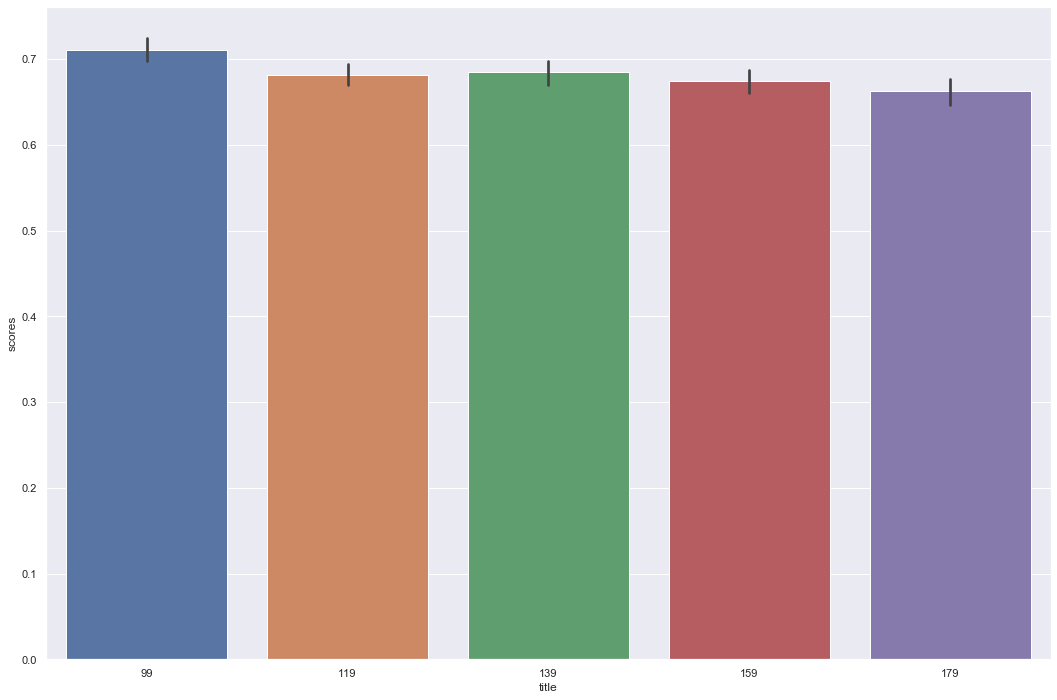

In [10]:
ax = sns.barplot(x="title", y="scores", data=df)

[Text(0, 0, '31948'),
 Text(0, 0, '48790'),
 Text(0, 0, '49444'),
 Text(0, 0, '49446'),
 Text(0, 0, '49465'),
 Text(0, 0, '49486'),
 Text(0, 0, '49589'),
 Text(0, 0, '52040'),
 Text(0, 0, '52049'),
 Text(0, 0, '52148'),
 Text(0, 0, '59396'),
 Text(0, 0, '59497'),
 Text(0, 0, '59519')]

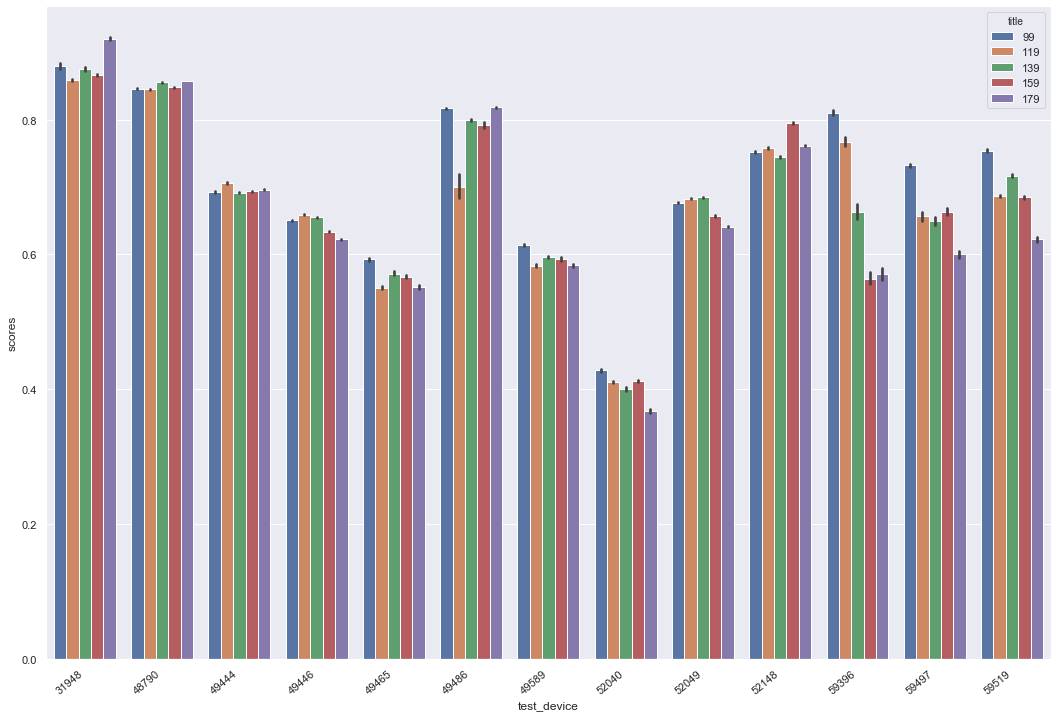

In [11]:
sns.set(rc={'figure.figsize':(18,12)})
ax = sns.barplot(x="test_device", y="scores", data=df, hue='title')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

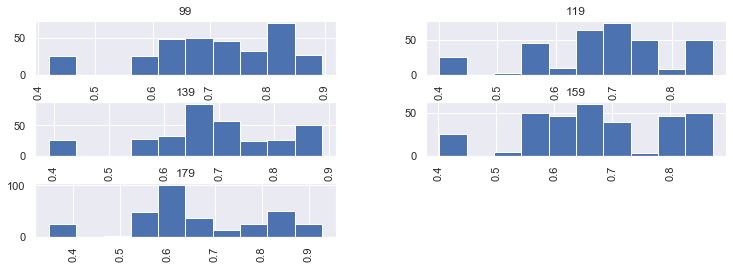

In [12]:
df.hist("scores", by="title", figsize=(12, 4));

In [13]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

C:\Python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The function `kdeplot` from PyMC3 is just an alias for `plot_kde` from ArviZ. Please switch to `pymc3.plot_kde` or `arviz.plot_kde`.
C:\Python\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, 9Hrs_std, 8Hrs_std, 7Hrs_std, 6hrs_std, 5Hrs_std, 9Hrs_mean, 8Hrs_mean, 7Hrs_mean, 6Hrs_mean, 5Hrs_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
C:\Python\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


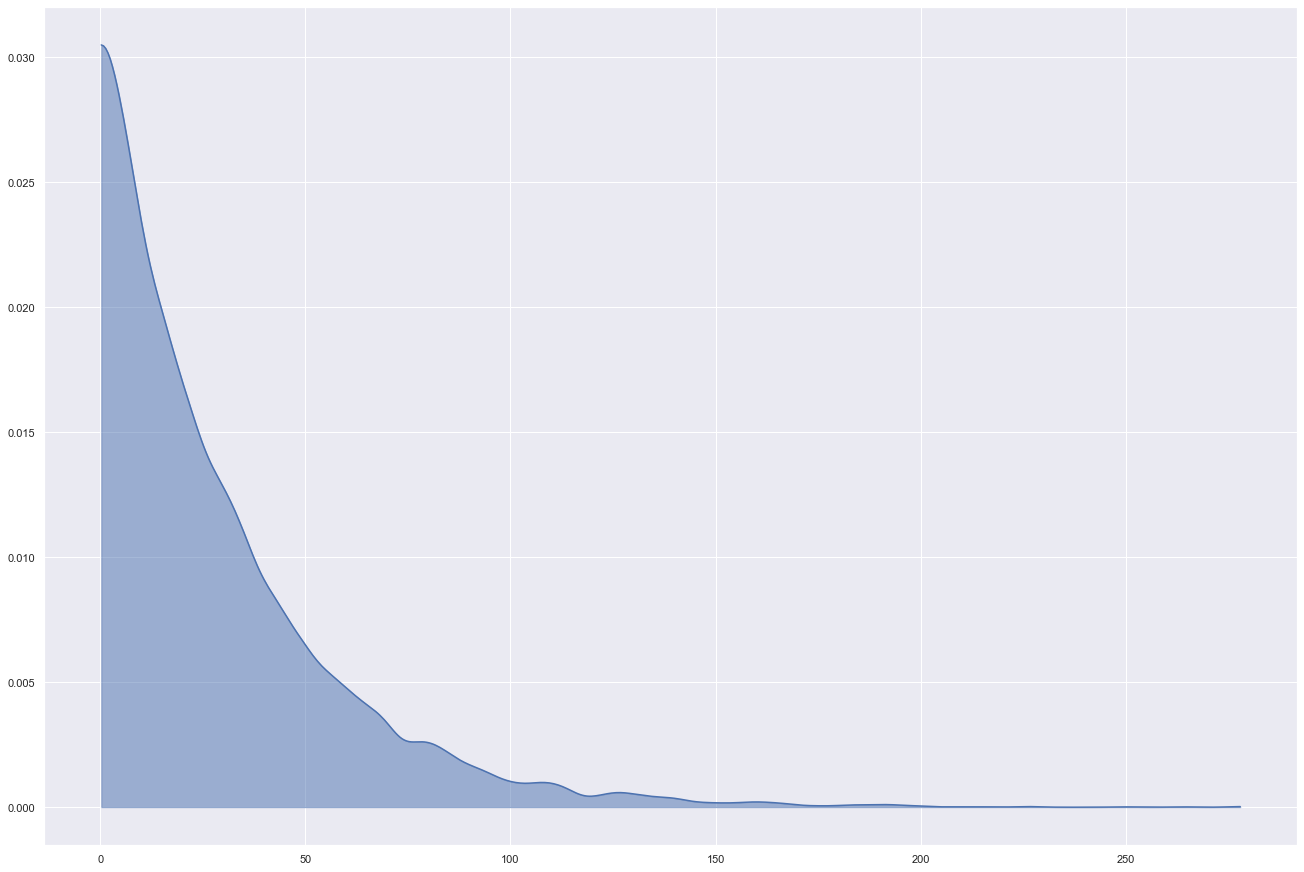

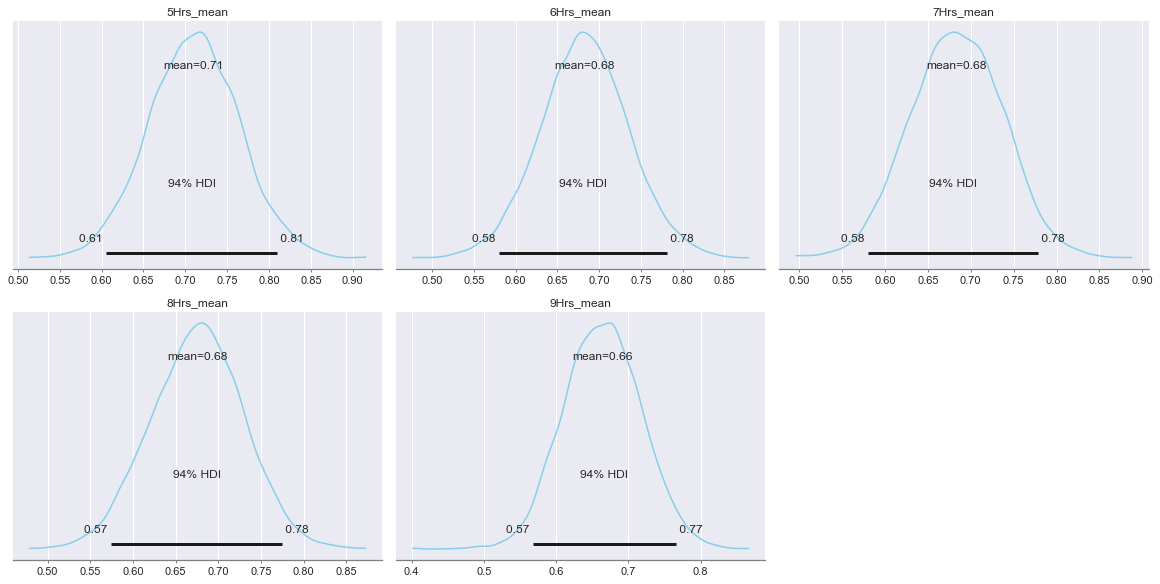

In [18]:
μ_m = df.scores.mean()
μ_s = df.scores.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal("5Hrs_mean", mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal("6Hrs_mean", mu=μ_m, sd=μ_s)
    group3_mean = pm.Normal("7Hrs_mean", mu=μ_m, sd=μ_s)
    group4_mean = pm.Normal("8Hrs_mean", mu=μ_m, sd=μ_s)
    group5_mean = pm.Normal("9Hrs_mean", mu=μ_m, sd=μ_s)

σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform("5Hrs_std", lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform("6hrs_std", lower=σ_low, upper=σ_high)
    group3_std = pm.Uniform("7Hrs_std", lower=σ_low, upper=σ_high)
    group4_std = pm.Uniform("8Hrs_std", lower=σ_low, upper=σ_high)
    group5_std = pm.Uniform("9Hrs_std", lower=σ_low, upper=σ_high)
    
with model:
    ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={"alpha": 0.5});

y1 = np.array(df[df.title == 99].scores)
y2 = np.array(df[df.title == 119].scores)
y3 = np.array(df[df.title == 139].scores)
y4 = np.array(df[df.title == 159].scores)
y5 = np.array(df[df.title == 179].scores)

with model:
    lam1 = group1_std ** -2
    lam2 = group2_std ** -2
    lam3 = group3_std ** -2
    lam4 = group4_std ** -2
    lam5 = group5_std ** -2

    group1 = pm.StudentT("5 Hours", nu=ν, mu=group1_mean, lam=lam1, observed=y1)
    group2 = pm.StudentT("6 Hours", nu=ν, mu=group2_mean, lam=lam2, observed=y2)
    group3 = pm.StudentT("7 Hours", nu=ν, mu=group3_mean, lam=lam3, observed=y3)
    group4 = pm.StudentT("8 Hours", nu=ν, mu=group4_mean, lam=lam4, observed=y4)
    group5 = pm.StudentT("9 Hours", nu=ν, mu=group5_mean, lam=lam5, observed=y5)

with model:
    trace = pm.sample(2000)
    
    
pm.plot_posterior(
    trace,
    var_names=["5Hrs_mean", "6Hrs_mean","7Hrs_mean","8Hrs_mean","9Hrs_mean"],
    color="#87ceeb",
    figsize=(16,8)
);

C:\Python\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.
C:\Python\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


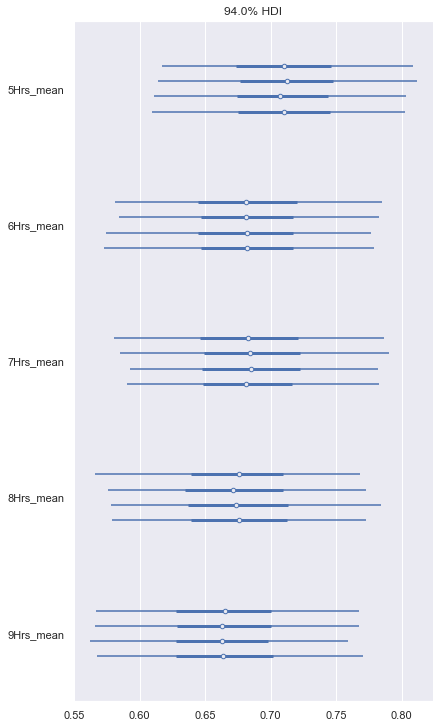

In [17]:
pm.forestplot(trace, var_names= ["5Hrs_mean", "6Hrs_mean","7Hrs_mean","8Hrs_mean","9Hrs_mean"]);